# Spotify Hit Classification

In this notebook I will attempt to build a classifier that determines how likely a song is to become a hit. The data comes from "The Spotify Hit Predictor Dataset (1960-2019)" on Kaggle.

## Data Description

- **Track**: The Name of the track.

- **Artist**: The Name of the Artist.

- **URI**: The resource identifier for the track.

- **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

- **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- **Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.

- **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

- **Mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

- **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:

- **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:

- **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- **Duration_Ms**:  The duration of the track in milliseconds.

- **TimeSignature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **Chorus_Hit**: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **Sections**: The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **Target**: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.

      The author's condition of a track being 'flop' is as follows:

        - The track must not appear in the 'hit' list of that decade.
        - The track's artist must not appear in the 'hit' list of that decade.
        - The track must belong to a genre that could be considered non-mainstream and / or avant-garde. 
        - The track's genre must not have a song in the 'hit' list.
        - The track must have 'US' as one of its markets.

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from optbinning import OptimalBinning
import math
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import tree, svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from SpotifyFunctions import DistributionPlot, Scatter, Distribution, InformationValue, Correlation, BarPlot, VariableBinning

from sklearn.ensemble import RandomForestClassifier

## Data Processing

To start, we iterate over each csv file in the directory and add to the main DataFrame along with a new column for identifying trends over time. We then standardise column names to have an uppercase first letter and define some new variables based on the data spec.

We then define the groups of continuous and discrete variable groups (for ease of plotting) and, finally, split the data into a randomly shuffled train and test split.

In [2]:
#Misc
Csv = ["dataset-of-60s", "dataset-of-70s", "dataset-of-80s", "dataset-of-90s", "dataset-of-00s", "dataset-of-10s"] 
Data = pd.DataFrame()

for Set in Csv:
    Temp = pd.read_csv(f"DataSets\{Set}.csv")
    Temp["decade"] = [Set.split("-")[-1].replace("s",'')]*len(Temp)

    Data = Data.append(Temp)
    
for Column in Data.columns.values:
    Data[str(Column).title()] = Data[Column]
    del Data[Column]
    
Data["LowEnergy"] = Data["Energy"].apply(lambda x: 1 if x <= 0.2 else 0)
Data["Acoustic"] = Data["Acousticness"].apply(lambda x: 1 if x >= 0.8 else 0)
Data["FourFour"] = Data["Time_Signature"].apply(lambda x: 1 if x == 4 else 0)
    
    
ContinuousVars = ['Danceability', 'Energy', 'Loudness', 'Speechiness',
                   'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
                   'Duration_Ms', 'Chorus_Hit', 'Sections']

DiscreteVars = ["Time_Signature", "Mode", "Key", "Acoustic", "FourFour", "LowEnergy"]

Train, Test = train_test_split(Data, test_size=0.33, random_state=42)

## EDA

Key points that stand out:

- Some mixes have greater than 0 Decibels (Loudness/Amplitude), which is typically a no-go in music production.
- Most datapoints are in Major (Mode), which is typically a happier sound.

In [4]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27541 entries, 5582 to 7153
Data columns (total 23 columns):
Track               27541 non-null object
Artist              27541 non-null object
Uri                 27541 non-null object
Danceability        27541 non-null float64
Energy              27541 non-null float64
Key                 27541 non-null int64
Loudness            27541 non-null float64
Mode                27541 non-null int64
Speechiness         27541 non-null float64
Acousticness        27541 non-null float64
Instrumentalness    27541 non-null float64
Liveness            27541 non-null float64
Valence             27541 non-null float64
Tempo               27541 non-null float64
Duration_Ms         27541 non-null int64
Time_Signature      27541 non-null int64
Chorus_Hit          27541 non-null float64
Sections            27541 non-null int64
Target              27541 non-null int64
Decade              27541 non-null object
LowEnergy           27541 non-null int64
Acou

In [5]:
Train.describe()

Danceability        Energy           Key      Loudness          Mode  \
count  27541.000000  27541.000000  27541.000000  27541.000000  27541.000000   
mean       0.538940      0.579881      5.235140    -10.230756      0.694855   
std        0.177713      0.253091      3.530833      5.337320      0.460477   
min        0.058800      0.000276      0.000000    -49.253000      0.000000   
25%        0.419000      0.396000      2.000000    -12.808000      0.000000   
50%        0.551000      0.602000      5.000000     -9.253000      1.000000   
75%        0.668000      0.789000      8.000000     -6.380000      1.000000   
max        0.988000      1.000000     11.000000      3.744000      1.000000   

        Speechiness  Acousticness  Instrumentalness      Liveness  \
count  27541.000000  27541.000000      27541.000000  27541.000000   
mean       0.072869      0.362689          0.156029      0.201929   
std        0.085707      0.339269          0.304606      0.173637   
min        0.022000      0.000000          0.000000      0.013000   
25%        0.033700      0.038100          0.000000      0.094100   
50%        0.043500      0.256000          0.000126      0.132000   
75%        0.069800      0.674000          0.066400      0.262000   
max        0.957000      0.996000          0.999000      0.999000   

            Valence         Tempo   Duration_Ms  Time_Signature    Chorus_Hit  \
count  27541.000000  27541.000000  2.754100e+04    27541.000000  27541.000000   
mean       0.542428    119.479224  2.349449e+05        3.894158     40.087749   
std        0.267499     29.127736  1.186840e+05        0.423119     18.993664   
min        0.000000     31.988000  1.562900e+04        1.000000      0.000000   
25%        0.329000     97.494000  1.730820e+05        4.000000     27.574260   
50%        0.559000    117.765000  2.179070e+05        4.000000     35.902170   
75%        0.769000    136.610000  2.667690e+05        4.000000     47.591410   
max        0.991000    241.423000  4.170227e+06        5.000000    433.182000   

           Sections        Target     LowEnergy      Acoustic      FourFour  
count  27541.000000  27541.000000  27541.000000  27541.000000  27541.000000  
mean      10.472786      0.498566      0.092335      0.167677      0.882974  
std        4.891409      0.500007      0.289504      0.373586      0.321457  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        8.000000      0.000000      0.000000      0.000000      1.000000  
50%       10.000000      0.000000      0.000000      0.000000      1.000000  
75%       12.000000      1.000000      0.000000      0.000000      1.000000  
max      169.000000      1.000000      1.000000      1.000000      1.000000

## Distributions

From the distribution plots, we can see many examples of the way in which our features interact with the target.

- We see that in general, hits tend to be more Danceable, this makes sense in general due to pop music typically being the type that people dance to.

- We see the same for energy - songs with more energy are more likely to be hits. Although, up to extreme levels of energy we see a drop in the volume of hits. This is possibly down to them correlating with certain genres like Metal or Heavy Dance music.

- As expected, louder mixes tend to make better hits than quieter. In the industry, producers (especially nowadays) tend to strive for louder and louder mixes.

- Very Acoustic songs tend not to make very good hits, this is possibly down to the low energy that often comes with these songs, these variables could possibly correlate with one another.

- Happier songs tend to make better hits, this is to be expected due to the positive impact happy songs can have on the listener.

- There is a clear sweet spot for duration, which definitely makes sense - listener attention span, radio conventions etc.

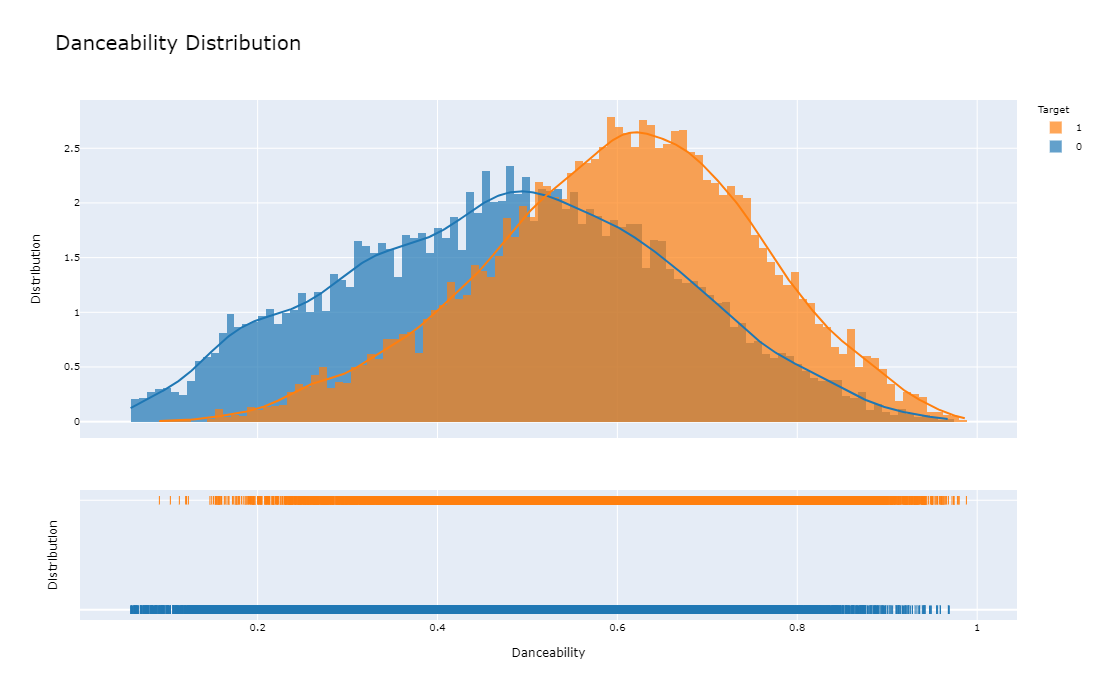

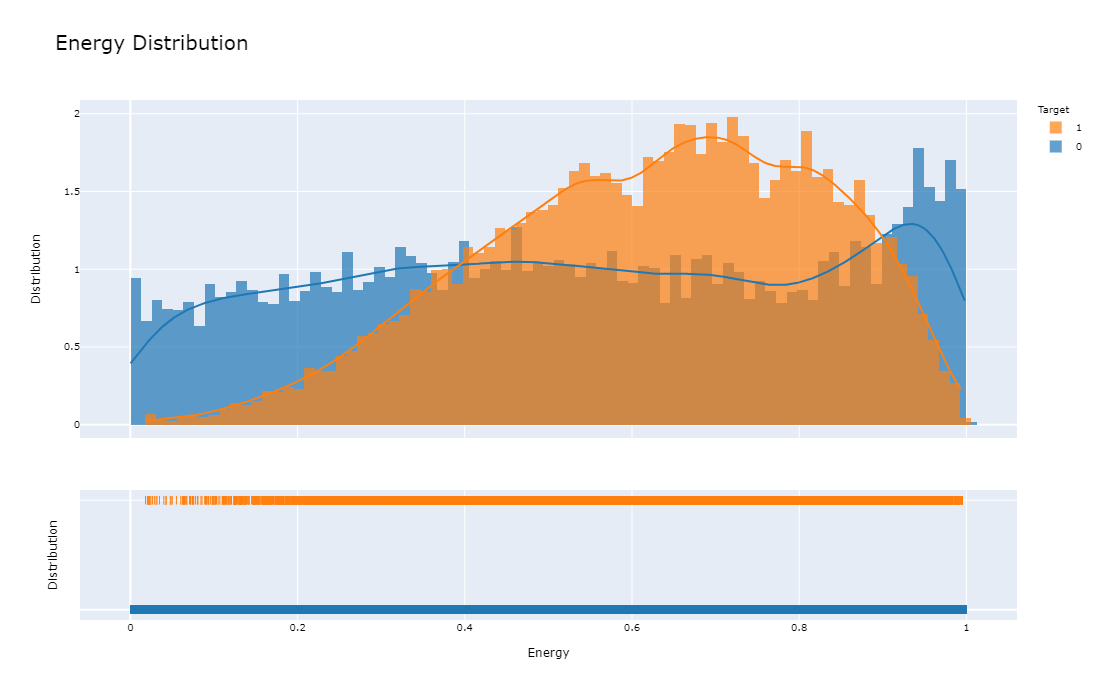

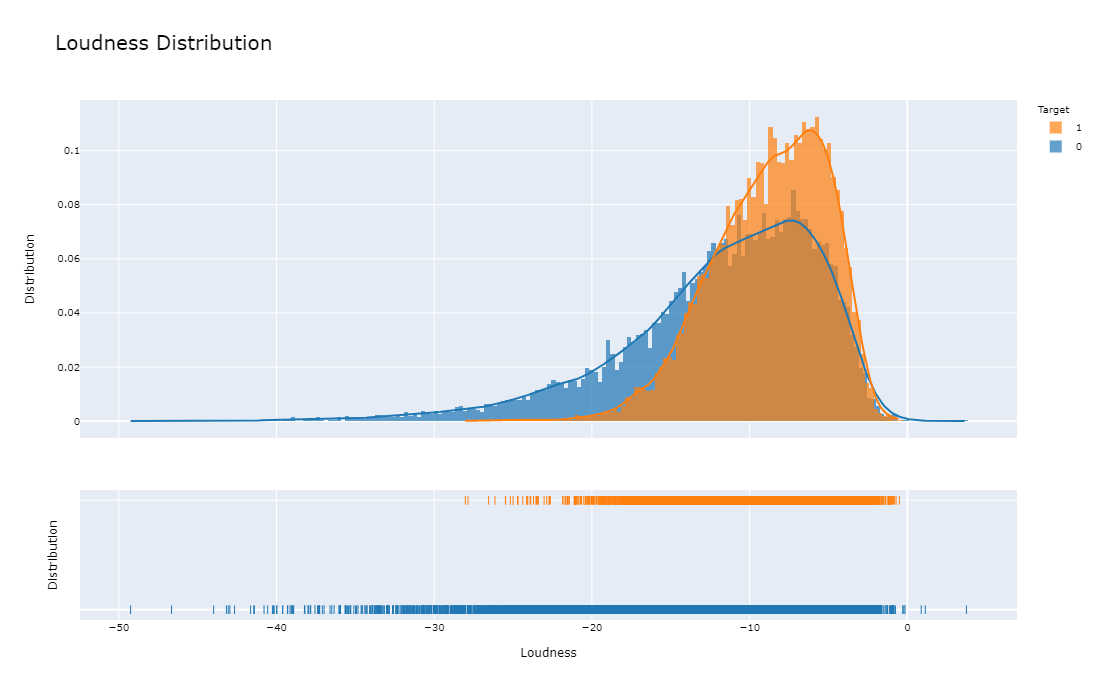

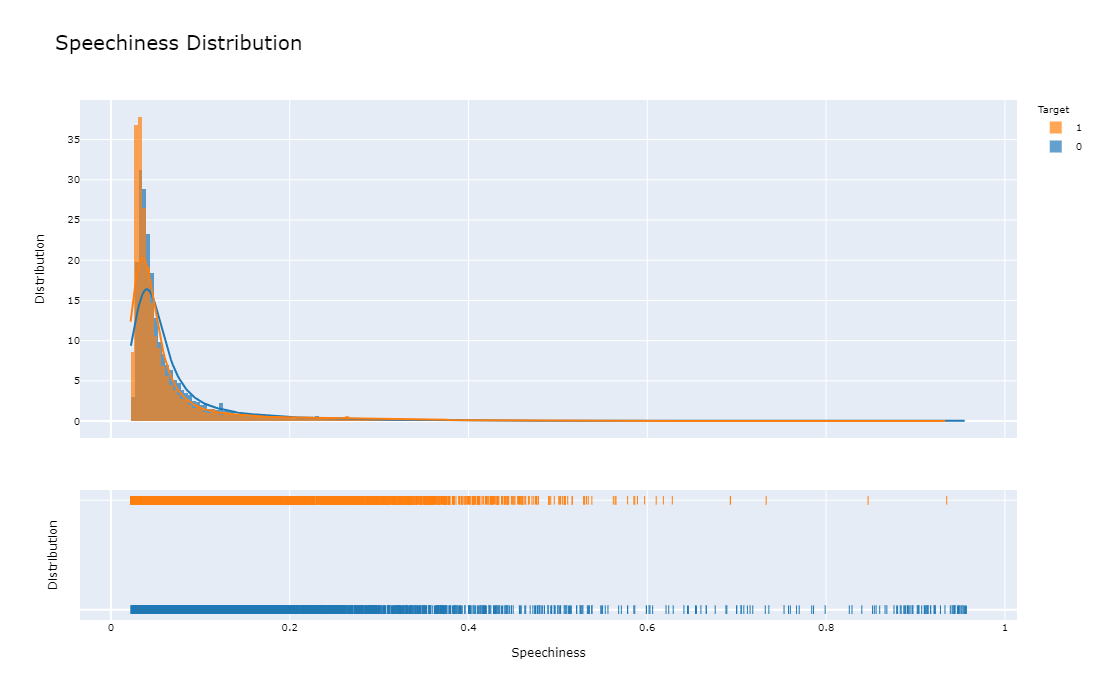

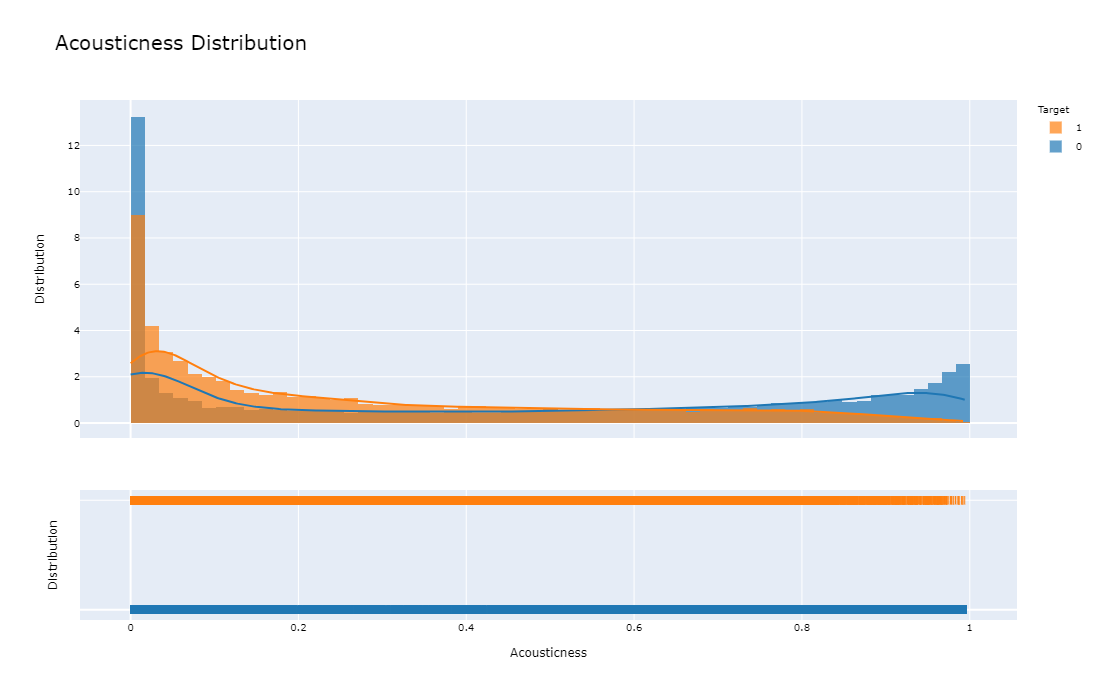

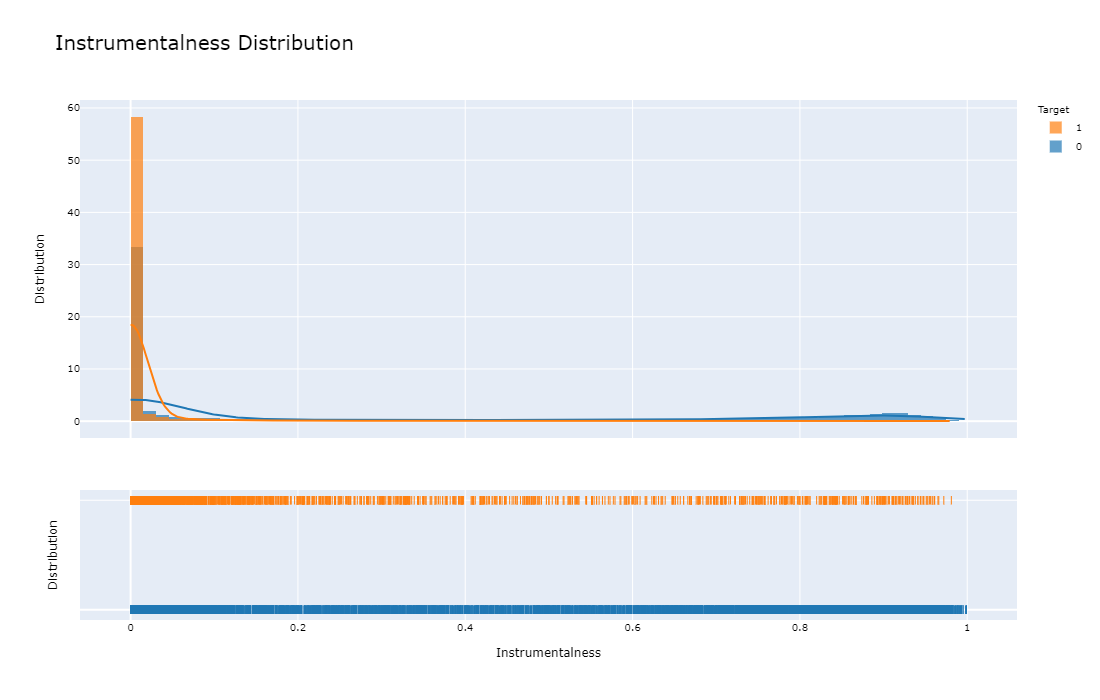

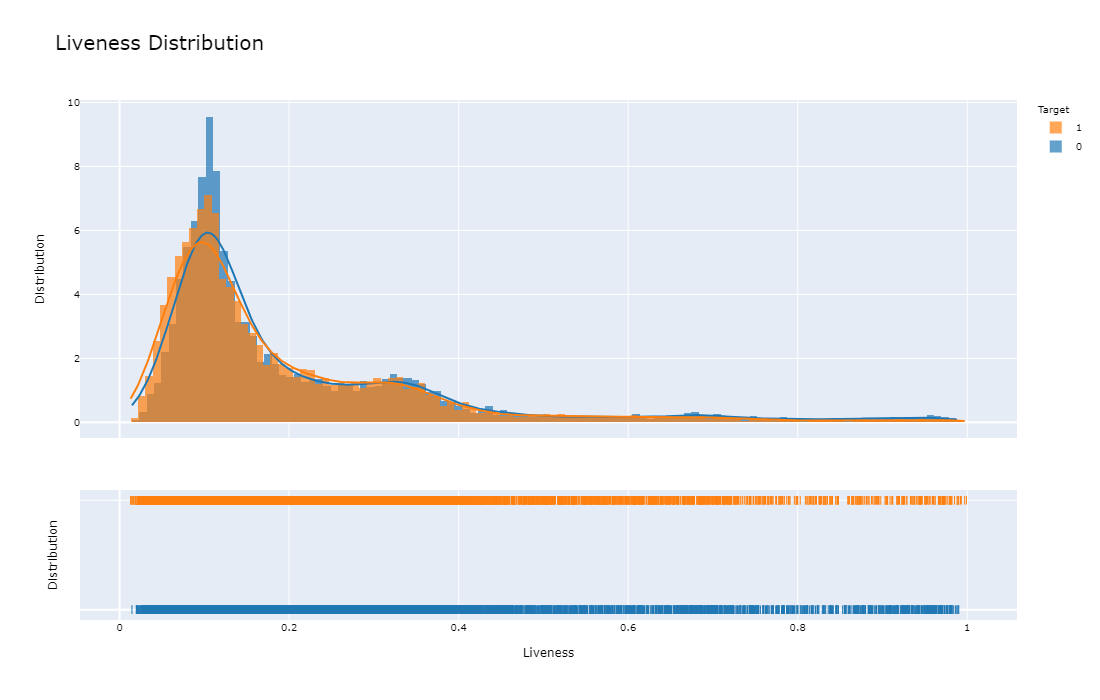

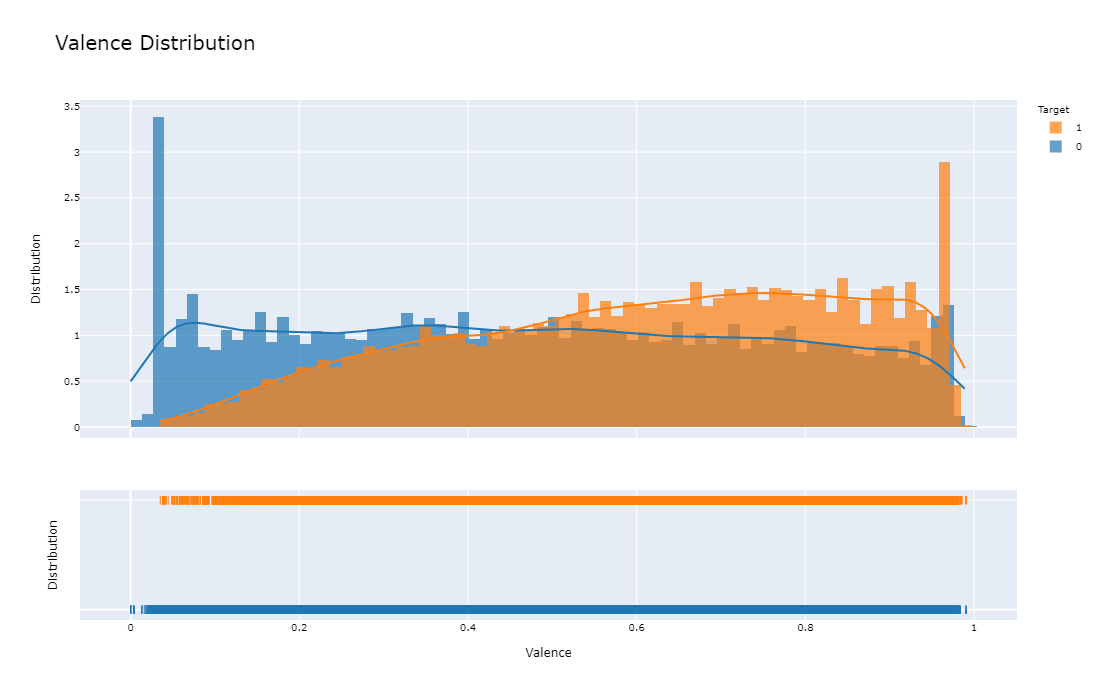

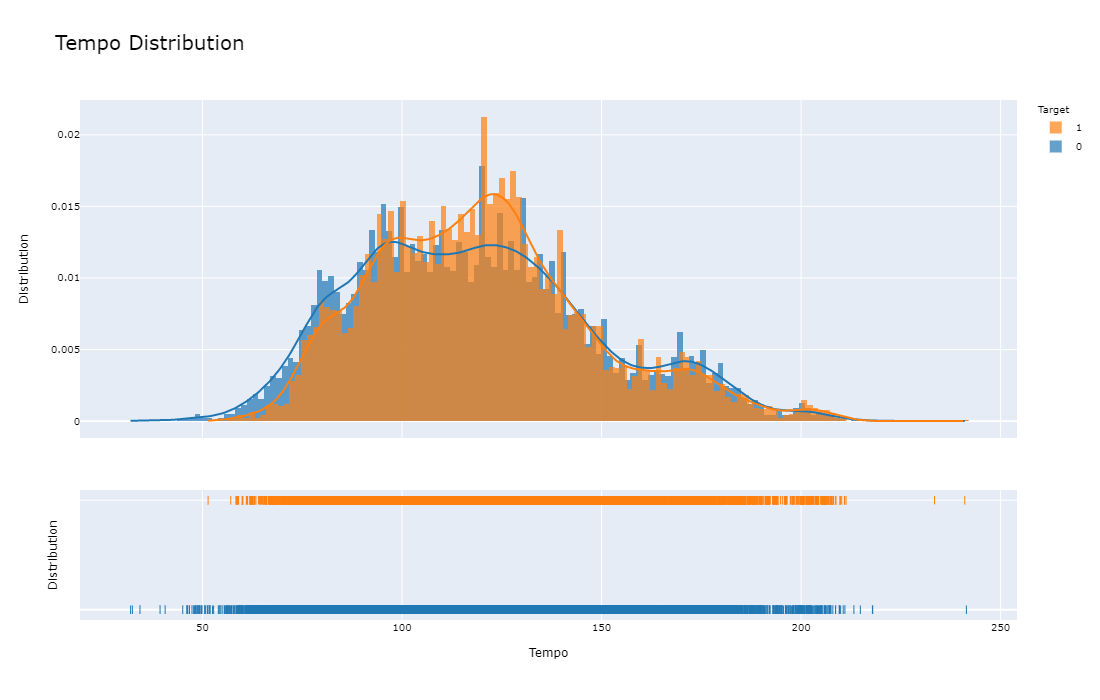

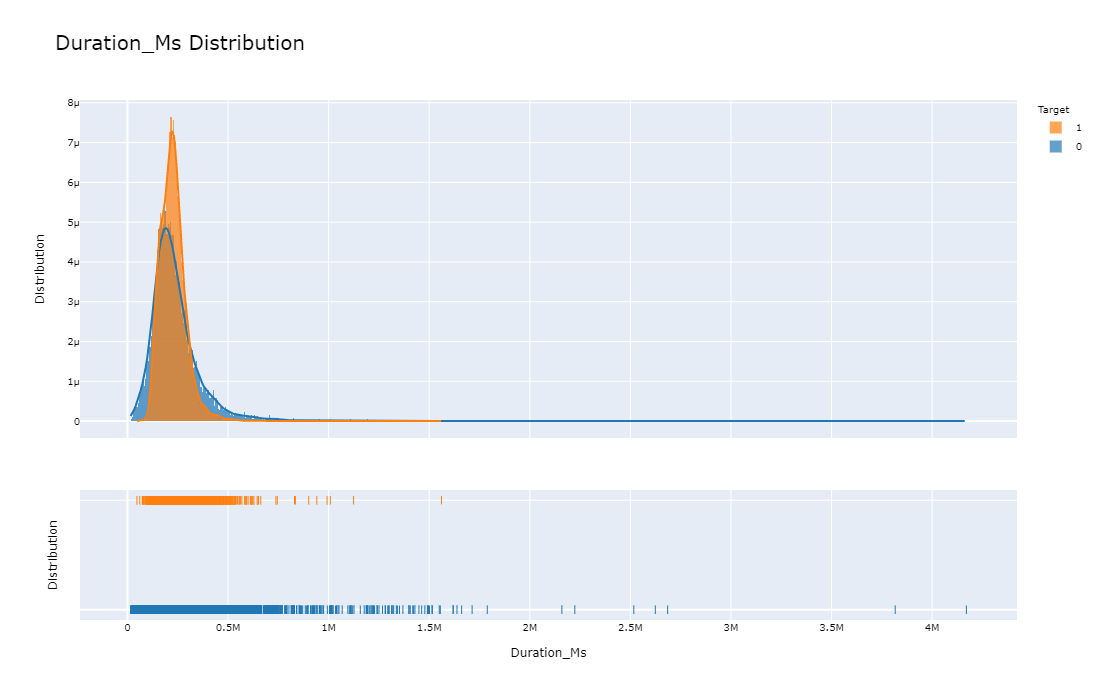

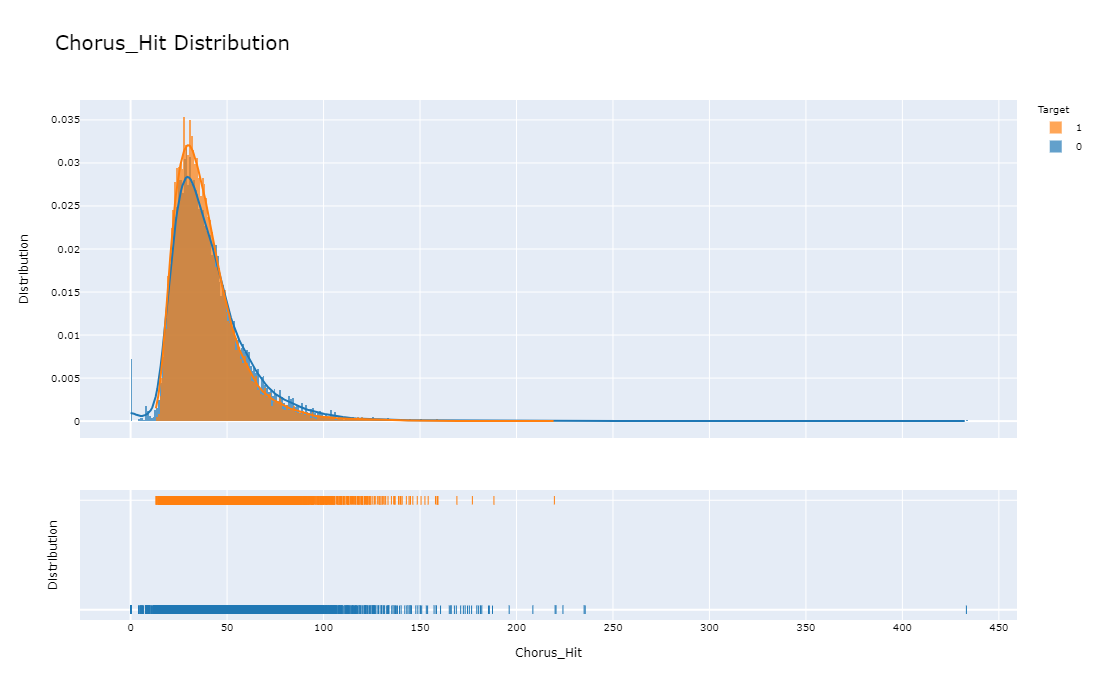

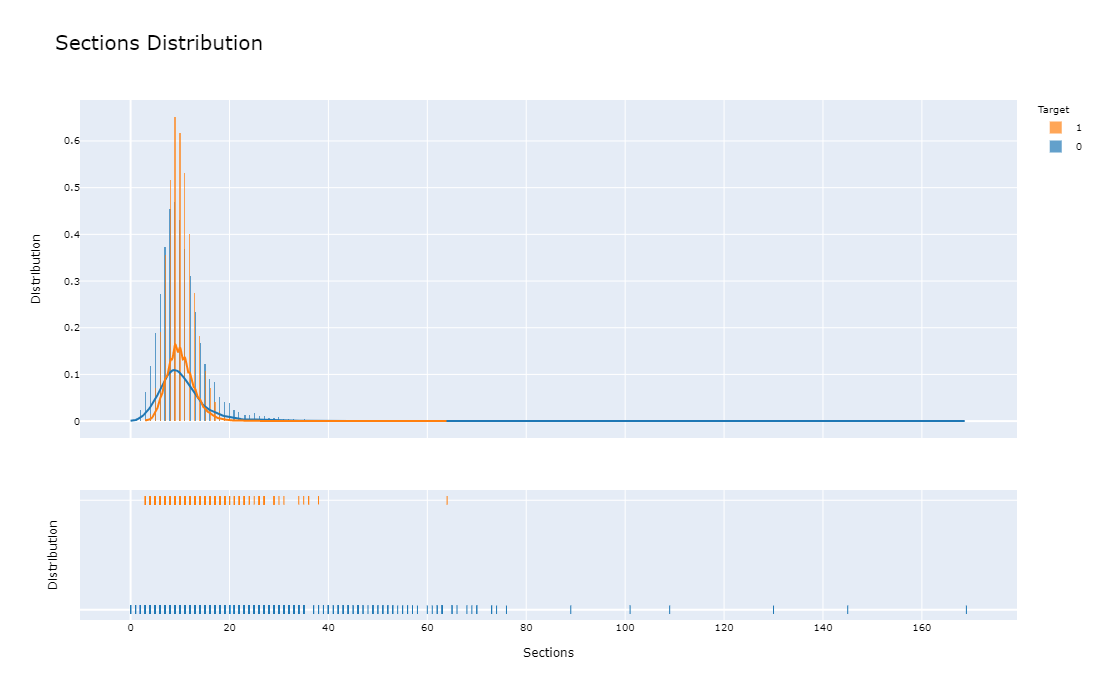

In [6]:
for Var in ContinuousVars:
    DistributionPlot(Train, Var)

## Testing combined variable impact on Target

- Songs that are hits tend to be more danceable and have higher energy together (No-Brainer)
- High Energy but undanceable songs are less likely to be hits, maybe particular Rock/Metal genres?
- Low energy Acoustic Songs tend to be Flops

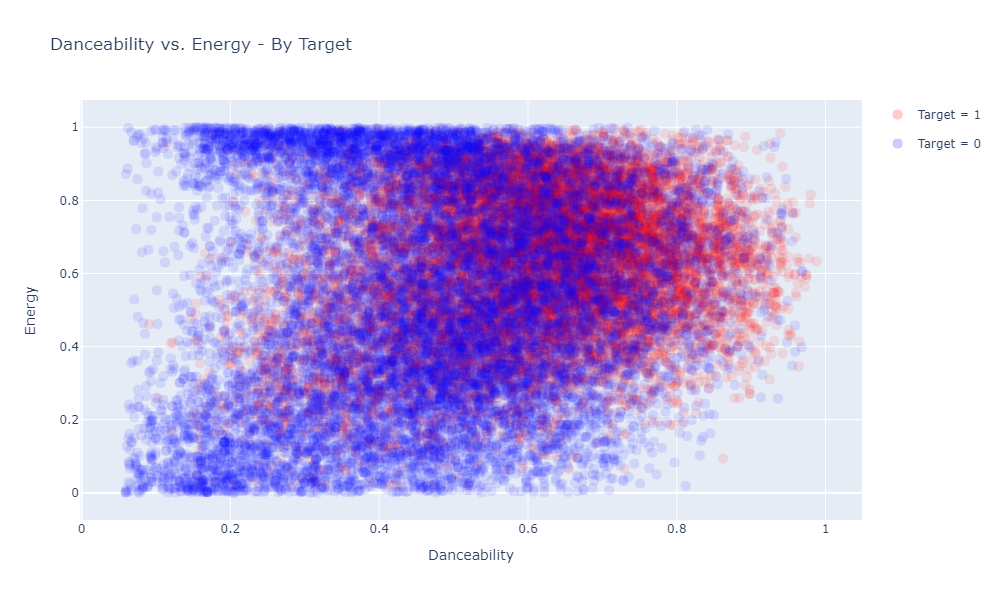

In [7]:
Scatter(Train, "Danceability", "Target", "Energy", "Danceability vs. Energy - By Target")

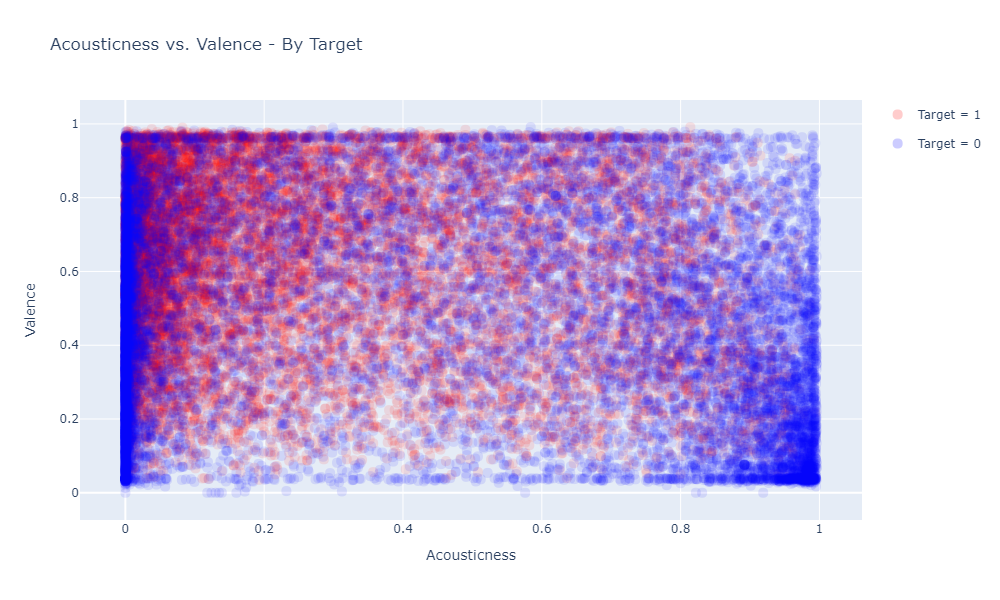

In [8]:
Scatter(Train, "Acousticness", "Target", "Valence", "Acousticness vs. Valence - By Target")

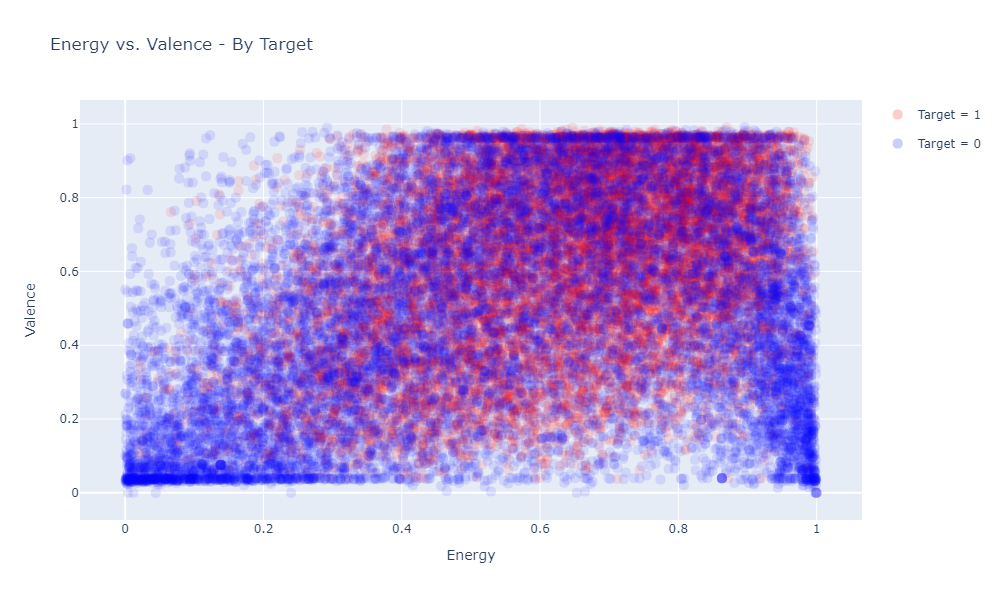

In [9]:
Scatter(Train, "Energy", "Target", "Valence", "Energy vs. Valence - By Target")

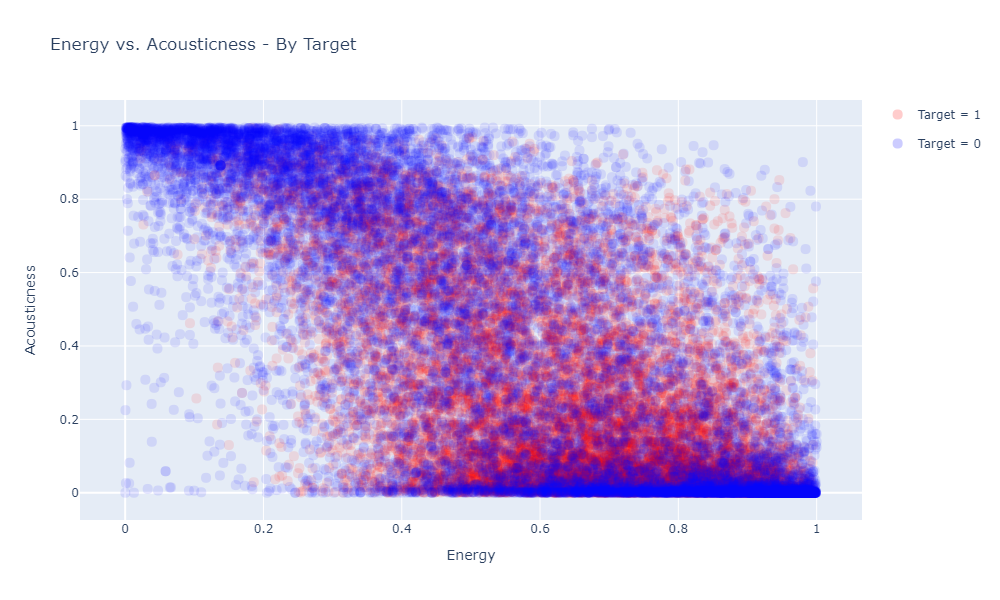

In [10]:
Scatter(Train, "Energy", "Target", "Acousticness", "Energy vs. Acousticness - By Target")

## Bin Variables and Clean
- We can see that, obviously, the most common signature is 4:4.
- We also see the host of non-linear relationships between features and the Target.

We use the optimal binning library in python to find the most optimal ways of binning our variables w.r.t the target. We bin our variables according to these definitions and perform a weight of evidence transformation, which defines a linear relationship between the cleaned variable and the log odds.

This technique is useful when you have noisy as well as missing data and can be performed on both categorical and numerical variables.

In [3]:
Variables = ["Mode", "Acoustic", "FourFour", "LowEnergy", "Liveness", "Instrumentalness", "Danceability"]

SquareVariables = ["Loudness", "Duration_Ms", "Energy", "Acousticness", "Tempo", "Sections"]

SqrtVariables = ["Valence"]

OrdinalVariables = ["Key"]

ModVars = Variables+SquareVariables+SqrtVariables+OrdinalVariables
ModVarsClean = [str(Variable)+"Clean" for Variable in ModVars]

for Variable in ModVars:
    Train[Variable+"Clean"] = Train[Variable]
    Test[Variable+"Clean"] = Test[Variable]

In [4]:
for Variable in DiscreteVars+OrdinalVariables+ContinuousVars:
    if Variable in DiscreteVars+OrdinalVariables:
        Binning = VariableBinning(Train, Variable, "Target", DType="categorical")
    else:
        Binning = VariableBinning(Train, Variable, "Target")
    Binning.BinVariable(Trend = "auto_asc_desc", Method = "bins", ShowTable = True)
    
    Train[str(Variable)+"Clean"] = Binning.Transform()
    Test[str(Variable)+"Clean"] = Binning.Transform(Test)

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.09804535
    IV (Jeffrey)             0.10040802
    JS (Jensen-Shannon)      0.01212161
    HHI                      0.78888865
    HHI (normalized)         0.73611081
    Cramer's V               0.15312026
    Quality score            0.10689093

  Significance tests

     Bin A  Bin B  t-statistic       p-value       P[A > B]  P[B > A]
         0      1    18.170828  2.019486e-05   5.772220e-06  0.999994
         1      2   441.608923  4.833747e-98  9.730925e-105  1.000000

None


OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07813096
    IV (Jeffrey)             0.02891598
    JS (Jensen-Shannon)      0.00360699
    HHI                      0.57593690
    HHI (normalized)         0.43458253
    Cramer's V               0.08483814
    Quality score            0.06793388

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1   198.226621  5.091330e-45  1.798364e-54       1.0

None


OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.06346070
    IV (Jeffrey)             0.01258506
    JS (Jensen-Shannon)      0.00157165
    HHI                      0.11458457
    HHI (normalized)         0.03409226
    Cramer's V               0.05603933
    Quality score            0.00000657

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1     1.729160  0.188518  0.093938  0.906062
         1      2     0.074687  0.784631  0.392263  0.607737
         2      3     3.382318  0.065899  0.032566  0.967434
         3      4     1.560386  0.211609  0.105579  0.894421
         4      5     0.009602  0.921939  0.460907  0.539093
         5      6     0.259726  0.610308  0.305057  0.694943
         6      7     0.121027  0.727923  0.363905  0.636095
         7      8     0.666034  0.414438  0

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.20948965
    IV (Jeffrey)             0.36072335
    JS (Jensen-Shannon)      0.04194902
    HHI                      0.72087678
    HHI (normalized)         0.62783571
    Cramer's V               0.28038050
    Quality score            0.36917068

  Significance tests

     Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
         0      1  2165.086799      0.0       0.0       1.0

None


OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.09729247
    IV (Jeffrey)             0.09694417
    JS (Jensen-Shannon)      0.01177803
    HHI                      0.79333890
    HHI (normalized)         0.72445186
    Cramer's V               0.15133281
    Quality score            0.10800073

  Significance tests

     Bin A  Bin B  t-statistic        p-value       P[A > B]  P[B > A]
         0      1   630.733475  3.461763e-139  7.279855e-153       1.0

None


OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.14202256
    IV (Jeffrey)             0.31261372
    JS (Jensen-Shannon)      0.03383578
    HHI                      0.83238140
    HHI (normalized)         0.77650853
    Cramer's V               0.24528977
    Quality score            0.21306066

  Significance tests

     Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
         0      1  1657.061329      0.0       0.0       1.0

None


OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.06346070
    IV (Jeffrey)             0.01258506
    JS (Jensen-Shannon)      0.00157165
    HHI                      0.11458457
    HHI (normalized)         0.03409226
    Cramer's V               0.05603933
    Quality score            0.00000657

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1     1.729160  0.188518  0.093938  0.906062
         1      2     0.074687  0.784631  0.392263  0.607737
         2      3     3.382318  0.065899  0.032566  0.967434
         3      4     1.560386  0.211609  0.105579  0.894421
         4      5     0.009602  0.921939  0.460907  0.539093
         5      6     0.259726  0.610308  0.305057  0.694943
         6      7     0.121027  0.727923  0.363905  0.636095
         7      8     0.666034  0.414438  0

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.39686761
    IV (Jeffrey)             0.63744042
    JS (Jensen-Shannon)      0.06920850
    HHI                      0.04381445
    HHI (normalized)         0.01393365
    Cramer's V               0.35644691
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1    14.794018  0.000120  0.000030  0.999970
         1      2     0.209310  0.647309  0.323008  0.676992
         2      3     2.383129  0.122652  0.056359  0.943641
         3      4    18.094406  0.000021  0.000004  0.999996
         4      5     0.024581  0.875415  0.438459  0.561541
         5      6     0.021388  0.883726  0.436520  0.563480
         6      7     0.028768  0.865316  0.437658  0.562342
         7      8     0.941096  0.331996  0

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.24259392
    IV (Jeffrey)             0.45445702
    JS (Jensen-Shannon)      0.04697164
    HHI                      0.41692131
    HHI (normalized)         0.38452805
    Cramer's V               0.28832884
    Quality score            0.00052575

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1    12.328675  0.000446  0.000147  0.999853
         1      2     4.186329  0.040751  0.022391  0.977609
         2      3     1.044481  0.306782  0.149202  0.850798
         3      4     3.888990  0.048604  0.023869  0.976131
         4      5     0.473113  0.491558  0.243641  0.756359
         5      6     3.691798  0.054681  0.025706  0.974294
         6      7     2.457009  0.117001  0.058973  0.941027
         7      8     4.644647  0.031151  0

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28397573
    IV (Jeffrey)             0.56029014
    JS (Jensen-Shannon)      0.05350360
    HHI                      0.10824721
    HHI (normalized)         0.06771300
    Cramer's V               0.30478742
    Quality score            0.00000069

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1    13.870926  0.000196  0.000014  0.999986
         1      2     8.531707  0.003490  0.001816  0.998184
         2      3     5.607001  0.017889  0.007583  0.992417
         3      4     8.083038  0.004468  0.002061  0.997939
         4      5     4.647511  0.031099  0.013906  0.986094
         5      6     4.487871  0.034136  0.017321  0.982679
         6      7     0.250401  0.616793  0.306287  0.693713
         7      8     3.557041  0.059293  0

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.16357654
    IV (Jeffrey)             0.13429961
    JS (Jensen-Shannon)      0.01623995
    HHI                      0.32321286
    HHI (normalized)         0.28561358
    Cramer's V               0.17759409
    Quality score            0.00000003

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1     5.600487  0.017955  0.991925  8.075092e-03
         1      2     8.093708  0.004442  0.998089  1.910668e-03
         2      3     0.052860  0.818160  0.594032  4.059676e-01
         3      4     3.315816  0.068616  0.965971  3.402909e-02
         4      5     1.357534  0.243965  0.877237  1.227626e-01
         5      6     0.070693  0.790330  0.604800  3.952001e-01
         6      7     0.170453  0.679710  0.661390  3.386102e-01
         7 

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28105733
    IV (Jeffrey)             0.59378422
    JS (Jensen-Shannon)      0.05693129
    HHI                      0.38800571
    HHI (normalized)         0.35200604
    Cramer's V               0.31479471
    Quality score            0.01844502

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1     2.371572  0.123563  0.937304  6.269646e-02
         1      2     4.509254  0.033712  0.983556  1.644401e-02
         2      3     2.989340  0.083814  0.958497  4.150258e-02
         3      4     0.993841  0.318805  0.840780  1.592199e-01
         4      5     7.869739  0.005027  0.998116  1.883773e-03
         5      6     0.106112  0.744615  0.627821  3.721787e-01
         6      7     0.870430  0.350836  0.825609  1.743914e-01
         7 

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.48138529
    IV (Jeffrey)             1.10894059
    JS (Jensen-Shannon)      0.11631065
    HHI                      0.11433122
    HHI (normalized)         0.07890447
    Cramer's V               0.45463745
    Quality score            0.00000054

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1    21.800976  0.000003  1.000000  2.709701e-08
         1      2     0.319036  0.572187  0.713378  2.866218e-01
         2      3     2.437402  0.118472  0.939929  6.007096e-02
         3      4     0.158579  0.690468  0.654427  3.455732e-01
         4      5     0.992758  0.319069  0.841716  1.582837e-01
         5      6     0.179100  0.672148  0.663837  3.361628e-01
         6      7     1.257448  0.262135  0.868932  1.310680e-01
         7 

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.08654465
    IV (Jeffrey)             0.04936358
    JS (Jensen-Shannon)      0.00606202
    HHI                      0.38181039
    HHI (normalized)         0.33765399
    Cramer's V               0.10920375
    Quality score            0.00006943

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1     2.190236  0.138888  0.933116  0.066884
         1      2     1.321175  0.250381  0.875248  0.124752
         2      3     0.608515  0.435347  0.781895  0.218105
         3      4     1.082528  0.298133  0.850438  0.149562
         4      5     0.003895  0.950235  0.525953  0.474047
         5      6     0.910658  0.339940  0.830213  0.169787
         6      7     2.077413  0.149493  0.925890  0.074110
         7      8     0.040005  0.841470  0

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28575863
    IV (Jeffrey)             0.51757215
    JS (Jensen-Shannon)      0.04780287
    HHI                      0.07875745
    HHI (normalized)         0.03688279
    Cramer's V               0.28924559
    Quality score            0.00011488

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1     3.776710  0.051971  0.016071  0.983929
         1      2     9.351851  0.002228  0.000526  0.999474
         2      3     0.664675  0.414914  0.200271  0.799729
         3      4     5.388888  0.020265  0.010067  0.989933
         4      5    11.633253  0.000648  0.000194  0.999806
         5      6     1.235149  0.266408  0.133866  0.866134
         6      7     4.071396  0.043615  0.020764  0.979236
         7      8     6.431067  0.011214  0

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07114515
    IV (Jeffrey)             0.04670636
    JS (Jensen-Shannon)      0.00552995
    HHI                      0.43309068
    HHI (normalized)         0.38584824
    Cramer's V               0.10263493
    Quality score            0.00014810

  Significance tests

     Bin A  Bin B  t-statistic   p-value      P[A > B]  P[B > A]
         0      1     7.836107  0.005121  2.073171e-03  0.997927
         1      2    23.337772  0.000001  9.729914e-08  1.000000
         2      3     0.142987  0.705329  3.511675e-01  0.648832
         3      4     0.210683  0.646233  3.232384e-01  0.676762
         4      5     1.351243  0.245061  1.222534e-01  0.877747
         5      6     1.394769  0.237601  1.185662e-01  0.881434
         6      7     0.066095  0.797110  3.985073e-01  0.601493
         7 

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.12042824
    IV (Jeffrey)             0.27827593
    JS (Jensen-Shannon)      0.02344681
    HHI                      0.47052784
    HHI (normalized)         0.42640516
    Cramer's V               0.19627091
    Quality score            0.00768205

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1     5.464132  1.941069e-02  5.822617e-03  0.994177
         1      2     4.331385  3.741579e-02  1.628508e-02  0.983715
         2      3    19.629266  9.401799e-06  1.084101e-06  0.999999
         3      4    26.769080  2.292767e-07  1.859113e-08  1.000000
         4      5     4.463761  3.462119e-02  1.667688e-02  0.983323
         5      6     0.013831  9.063804e-01  4.540095e-01  0.545991
         6      7     2.991831  8.368549e-02  4.

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.06106480
    IV (Jeffrey)             0.02053084
    JS (Jensen-Shannon)      0.00255140
    HHI                      0.40020299
    HHI (normalized)         0.33355887
    Cramer's V               0.07121329
    Quality score            0.00051675

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1     0.048144  0.826324  0.586642  0.413358
         1      2     1.057928  0.303688  0.848448  0.151552
         2      3     1.748560  0.186058  0.907200  0.092800
         3      4     1.873189  0.171110  0.914848  0.085152
         4      5     0.039733  0.842004  0.578990  0.421010
         5      6     1.154961  0.282513  0.858657  0.141343
         6      7     5.542878  0.018556  0.991343  0.008657

None


OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.08435262
    IV (Jeffrey)             0.14221372
    JS (Jensen-Shannon)      0.01480740
    HHI                      0.79580327
    HHI (normalized)         0.77027868
    Cramer's V               0.16155656
    Quality score            0.08993073

  Significance tests

     Bin A  Bin B  t-statistic       p-value  P[A > B]      P[B > A]
         0      1     9.014482  2.678487e-03  0.999962  3.842444e-05
         1      2     1.275788  2.586836e-01  0.871159  1.288414e-01
         2      3    10.630013  1.112669e-03  0.999632  3.682922e-04
         3      4     4.022092  4.490798e-02  0.978130  2.186969e-02
         4      5    11.331359  7.620911e-04  0.999770  2.300378e-04
         5      6    30.399582  3.516040e-08  1.000000  1.534256e-10

None


## Variable Correlations

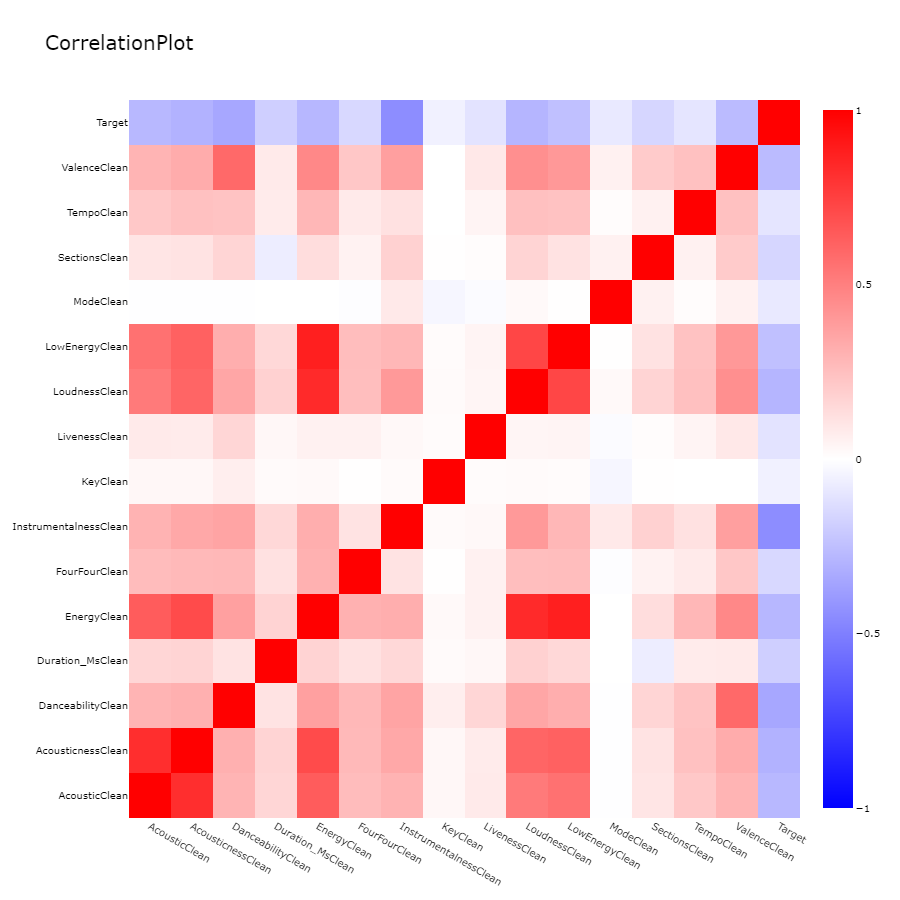

In [5]:
Correlation(Train, sorted(ModVarsClean)+["Target"], "CorrelationPlot")

## Modelling

We choose our selection of classifiers:

- Logistic Regression
- Decision Tree
- Random Forest

We then perform a grid search on each (not including logistic regression) to find the optimal parameters and plot feature importances. Finally, we compare our models using a series of metrics.

To test feature importance for a logistic regression model you might scale your input features between 0 and 1 (a comparable range) in order to compare feature importances/relationship with log-odds, because we have performed a woe transformation, this cannot be done and one would typically use a technique know as Information Value to determine feature importance, this can also be used to select features.

I have also plotted the Information Gain for each feature below the coefficients.

When fitting this model, l1 (Lasso) regularisation was used, meaning the fitting process would shrink any irrelevant coefficients to 0 and therefore performing feature selection, however, all features were significant.

In both the Decision Tree and the Random Forest classifiers, a grid search was used to determine the optimal parameters. This increased training time down to the fact that grid search is exhaustive, testing all possible combinations of the parameter grid. The parameter grid included max_depth and n_samples_split. n_estimators was used for the Random Forest Classifier.

- max_depth: Maximum depth of the tree, or number of layers of splits/nodes.
- min_samples_split: Minimum number of samples required to split a node further.
- n_estimators: Number of weak learners in the Random Forest Classifier.

All three parameters help to reduce overfitting, by managing how complex the model is.

For both the Decision Tree and Random Forest classifiers, instrumentalness is the most important feature. This is measured by combining information about the number of samples that reached this node during training and the decrease in gini impurity provides.

In [6]:
X = ['AcousticClean', 'DanceabilityClean', 'Duration_MsClean'
     , 'EnergyClean', 'FourFourClean', 'InstrumentalnessClean'
     , 'KeyClean', 'LivenessClean', 'LoudnessClean'
     , 'LowEnergyClean', 'ModeClean', 'SectionsClean', 'ValenceClean']

Y = "Target"

In [7]:
Scores = {}
Precisions = {}
Recalls = {}
Aucs = {}

### Logistic Regression

In [8]:
Mod = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

In [9]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.coef_[0][i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

In [10]:
Aucs["LogisticRegressionTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["LogisticRegressionTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["LogisticRegressionTrain"] = precision_score(TrainPreds, Train[Y])
Scores["LogisticRegressionTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["LogisticRegressionTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["LogisticRegressionTest"] = recall_score(TestPreds, Test[Y])
Precisions["LogisticRegressionTest"] = precision_score(TestPreds, Test[Y])
Scores["LogisticRegressionTest"] = accuracy_score(TestPreds, Test[Y])

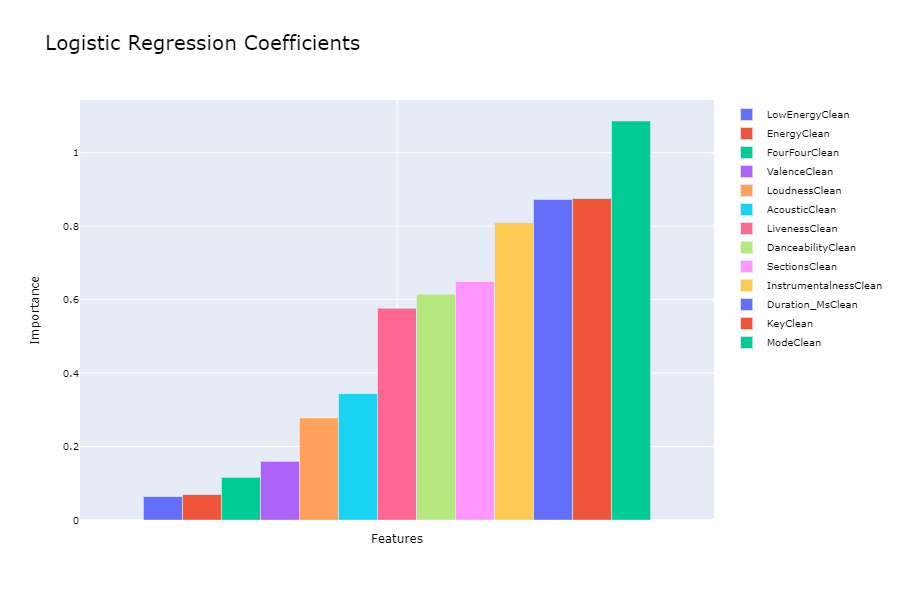

In [11]:
BarPlot(FeatureImportance, "Logistic Regression Coefficients")

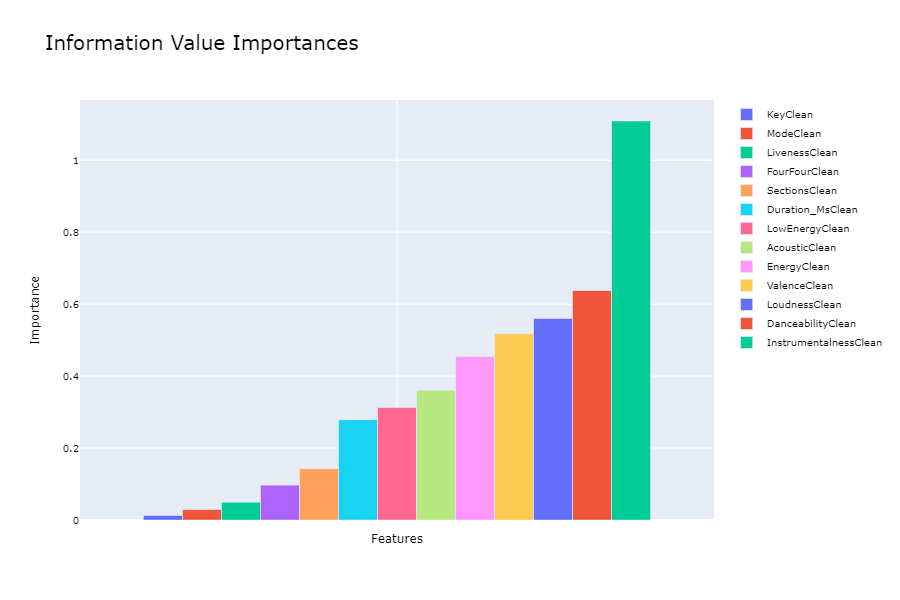

In [12]:
for Variable in X:
    FeatureImportance[Variable] = InformationValue(Train, Variable, "Target")
FeatureImportance = FeatureImportance.T.sort_values(by=1).T
BarPlot(FeatureImportance, "Information Value Importances")

### Decision Tree

In [13]:
ParamGrid = {'max_depth': np.arange(3, 10)
             , 'min_samples_split': [int(0.01*len(Train)*i) for i in range(1, 10)]
            }

Mod = GridSearchCV(tree.DecisionTreeClassifier(), ParamGrid, cv=5)

Mod = Mod.fit(Train[X], Train[Y])

print('Decision Tree Best Params: {}'.format(Mod.best_params_))

Mod = tree.DecisionTreeClassifier(max_depth = Mod.best_params_["max_depth"]
                                  , min_samples_split = Mod.best_params_["min_samples_split"])
Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

Decision Tree Best Params: {'max_depth': 9, 'min_samples_split': 275}


In [14]:
Aucs["DecisionTreeTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["DecisionTreeTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["DecisionTreeTrain"] = precision_score(TrainPreds, Train[Y])
Scores["DecisionTreeTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["DecisionTreeTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["DecisionTreeTest"] = recall_score(TestPreds, Test[Y])
Precisions["DecisionTreeTest"] = precision_score(TestPreds, Test[Y])
Scores["DecisionTreeTest"] = accuracy_score(TestPreds, Test[Y])

In [15]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.feature_importances_[i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

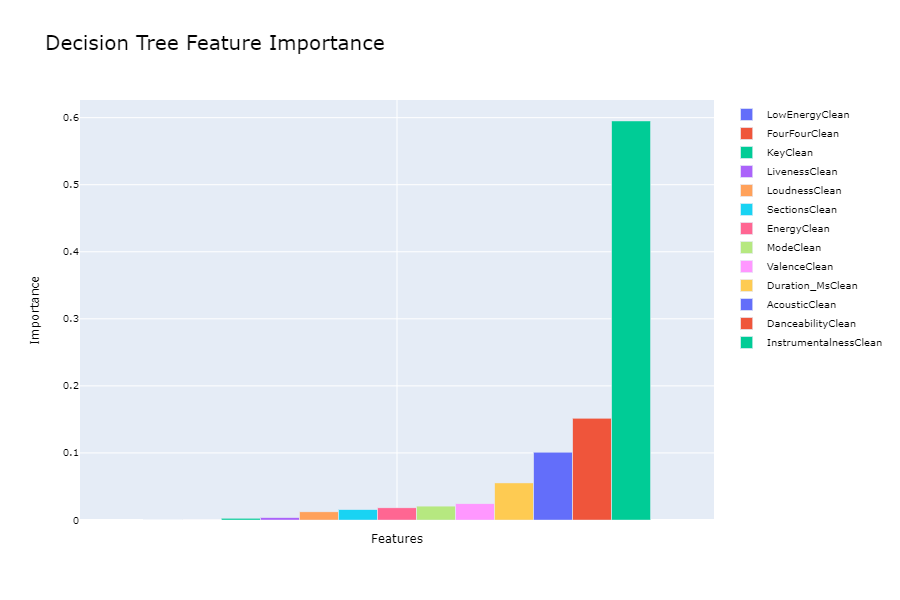

In [16]:
BarPlot(FeatureImportance, "Decision Tree Feature Importance")

### Random Forest

In [17]:
ParamGrid = {'n_estimators': np.arange(100, 200, 50)
             , 'max_depth': np.arange(5, 10)
             , 'min_samples_split': [int(0.01*len(Train)*i) for i in range(1, 5)]
            }

Mod = GridSearchCV(RandomForestClassifier(), ParamGrid, cv=5)

Mod = Mod.fit(Train[X], Train[Y])

print('Random Forest Best Params: {}'.format(Mod.best_params_))

Mod = RandomForestClassifier(max_depth = Mod.best_params_["max_depth"]
                             , n_estimators = Mod.best_params_["n_estimators"]
                             , min_samples_split = Mod.best_params_["min_samples_split"])

Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

Random Forest Best Params: {'max_depth': 9, 'min_samples_split': 275, 'n_estimators': 150}


In [18]:
Aucs["RandomForestTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["RandomForestTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["RandomForestTrain"] = precision_score(TrainPreds, Train[Y])
Scores["RandomForestTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["RandomForestTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["RandomForestTest"] = recall_score(TestPreds, Test[Y])
Precisions["RandomForestTest"] = precision_score(TestPreds, Test[Y])
Scores["RandomForestTest"] = accuracy_score(TestPreds, Test[Y])

In [19]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.feature_importances_[i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

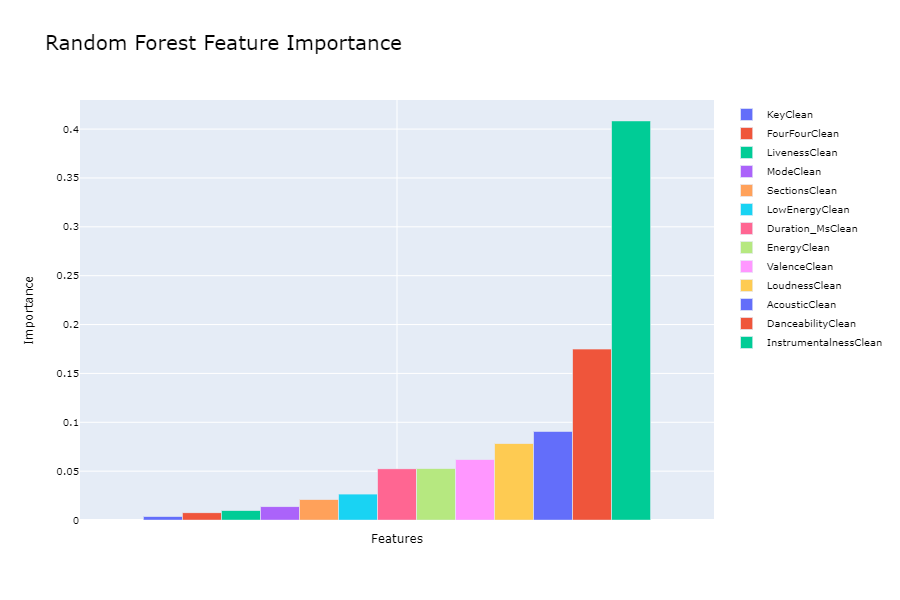

In [20]:
BarPlot(FeatureImportance, "Random Forest Feature Importance")

## Model Comparison

In most cases, it is useful to decide on a single metric for which to compare models. The choice of metric will often depend on your specific use case. If you were mainly concerned about minimising false negatives, you might choose Recall. Otherwise, you might use Precision. F1 score takes into account both Precision and Recall, giving a more balanced view. For simplicity, I will use the F1 score to compare models, making our model of choice the Random Forest Classifier.

A practical application of this project would be for a Record Company to use these techniques to determine which artists they would like to sign, judging by the features of their top songs. In this case, you could argue that the user would be mainly concerned with false negatives, as they'd be trying to minimise the event of signing an artist that Flops. Which would make Recall the metric of choice.

In [21]:
Comparison = pd.DataFrame()
Models = ["LogisticRegression", "DecisionTree", "RandomForest"]

Comparison["ScoreTrain"] = [Scores[str(Model)+"Train"] for Model in Models]
Comparison["ScoreTest"] = [Scores[str(Model)+"Test"] for Model in Models]

Comparison["PrecisionsTrain"] = [Precisions[str(Model)+"Train"] for Model in Models]
Comparison["PrecisionsTest"] = [Precisions[str(Model)+"Test"] for Model in Models]

Comparison["RecallsTrain"] = [Recalls[str(Model)+"Train"] for Model in Models]
Comparison["RecallsTest"] = [Recalls[str(Model)+"Test"] for Model in Models]

Comparison["AucsTrain"] = [Aucs[str(Model)+"Train"] for Model in Models]
Comparison["AucsTest"] = [Aucs[str(Model)+"Test"] for Model in Models]

Comparison.index = Models

In [22]:
Comparison

ScoreTrain  ScoreTest  PrecisionsTrain  PrecisionsTest  \
LogisticRegression    0.749101   0.739550         0.839779        0.835679   
DecisionTree          0.756617   0.745522         0.844148        0.839343   
RandomForest          0.763080   0.752820         0.844294        0.839050   

                    RecallsTrain  RecallsTest  AucsTrain  AucsTest  
LogisticRegression      0.709993     0.702699   0.757651  0.748543  
DecisionTree            0.717531     0.708488   0.764799  0.754299  
RandomForest            0.725469     0.717383   0.770269  0.760410